## 프로젝트 : 모든 장르 간 편향성 측정해 보기

#### [프로젝트 개요]
- 전체 영화 장르 시놉시스를 속성(attribute)으로 두고, 예술 vs 일반 영화를 타깃(target)으로 설정해, 각 장르가 예술/일반에 대해 어떤 편향성을 보이는지 WEAT로 측정하기

#### [프로젝트 구조]
- **타깃(Target, X vs Y)**
    - 예술 영화 (예술 TXT)
    - 일반 영화 (일반 TXT)
- **속성(Attribute, A vs B)**
    - 각 장르별로 뽑은 대표 단어셋 (PMI/TF-IDF 기반)
    - 드라마 장르 A(드라마 대표 단어), B(비-드라마 대표 단어)
- **WEAT(Word Embedding Association Test)**
    - 타깃(X=예술, Y=일반)과 속성(A/B : 장르별 단어) 사이의 연관성을 효과크기 d로 계산
    - 값이 크고 p<0.05이면 → 해당 장르가 특정 타깃(예술/일반)에 더 강한 편향을 보임

#### [최종 목표]
- 모든 장르에 대해 WEAT d를 계산 → 히트맵으로 시각화
- 어떤 장르 속성 단어들이 예술에 더 가깝고, 어떤 장르들이 일반에 더 가깝게 인식되는지 확인

### 1. 라이브러리 불러오기

In [35]:
import os, re, random, math, json
import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd

from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

random.seed(42); np.random.seed(42)

### 2. STEP 1 ~ 2 함수 미리 정의하기

- 시스템에 설치된 폰트 중 한글 지원 폰트를 찾는 함수
- 매번 root 권한이 없어서 한글 폰트 오류가 발생하여 /work/에 NanumGothic을 설치했음

In [135]:
def _set_korean_font():
    try:
        font_path = "/home/jovyan/work/NanumGothic.ttf"
        fontprop = fm.FontProperties(fname=font_path)
        plt.rc('font', family=fontprop.get_name())
        plt.rcParams['axes.unicode_minus'] = False
    except Exception as e:
        print("폰트 설정 실패:", e)

_set_korean_font()

In [137]:
# 파일을 자동으로 여러 인코딩 방식으로 시도해서 읽어주는 함수
def read_token(path, enc_list=("utf-8","cp949","euc-kr")):
    for enc in enc_list:
        try:
            with open(path, "r", encoding=enc) as f:
                return f.read()
        except Exception:
            continue
    raise IOError(f"파일 인코딩을 알 수 없습니다: {path}")

### 2-1. 형태소 분석기를 이용하여 품사가 명사인 경우 해단 단어를 추출하는 함수

- Okt 형태소 분석기를 이용해서 명사를 추출
- HANGUL을 이용해서 추출된 토큰 중 한글만 남김
- STOP을 이용해서 흔한 불용어를 제거

In [139]:
OKT = Okt()
HANGUL = re.compile(r"[가-힣]+")
STOP = set(["것","수","등","때","같이","처럼","및","중","후","전","더","그","이","저","그리고","하지만","그러나","또한","또"])

In [141]:
# 형태소 분석기로 뽑은 명사 중 의미있는 한글 단어만 남기는 전처리 함수

def tokenize_nouns(text:str):
    return [w for w in OKT.nouns(text) if len(w)>1 and HANGUL.fullmatch(w) and w not in STOP]

1. OKT.nouns(text)
- Okt 형태소 분석기로 입력된 문장에서 명사만 추출
- 예 : "나는 학교에 간다" → ["나", "학교"]

2. len(w) > 1
- 한 글자짜리 명사는 버림 (잡음 제거)
- "나" 같은 단어는 제외, "학교" 같은 단어는 유지

3. HANGUL.fullmatch(w)
- 정규식 검사 : w가 오직 한글로만 구성된 단어일 때만 통과
- "AI", "123", "A.I." 같은 건 제외
- "학교", "사랑" 같은 건 포함

4. w not in STOP
- 불용어 집합(STOP)에 포함된 흔한 단어들은 제외
- "것", "수", "그리고" 같은 의미 없는 단어는 버림

### 2-2. 추출된 결과로 임베딩 모델 만드는 함수

In [143]:
# 단어 임베딩 벡터 사이의 방향적 유사성을 측정

def cos_sim(a:np.ndarray, b:np.ndarray):
    return float(dot(a,b)/(norm(a)*norm(b)+1e-12))

In [145]:
# WEAT 계산에서 연관도 점수를 구하는 함수

def s(w, A, B, model):
    if w not in model.wv: 
        return np.nan
    return np.mean([model.wv.similarity(w,a) for a in A if a in model.wv]) - np.mean([model.wv.similarity(w,b) for b in B if b in model.wv])

In [146]:
# WEAT의 최종 효과 크기를 계산하는 함수

def weat_score(model, X, Y, A, B):
    Xv = [w for w in X if w in model.wv]; Yv = [w for w in Y if w in model.wv]
    if len(Xv)==0 or len(Yv)==0: return np.nan
    sX = [s(w,A,B,model) for w in Xv]; sY = [s(w,A,B,model) for w in Yv]
    pooled = np.std(sX+sY, ddof=1)
    if pooled==0: return np.nan
    return (np.mean(sX) - np.mean(sY)) / pooled

[입력 인자]

- w : target 단어 (예술/일반 단어 중 하나)
- A : attribute 단어셋 A (예 : 특정 장르 대표 단어 집합)
- B : attribute 단어셋 B (해당 장르의 반대 축 단어 집합)
- model : 학습된 Word2Vec/FastText 모델

[if w not in model.wv: return np.nan]
- 단어 w가 임베딩 모델 어휘에 없으면 계산 불가 → NaN 반환

[np.mean([model.wv.similarity(w,a) for a in A if a in model.wv])]
- w와 A 집합의 모든 단어 간 코사인 유사도 평균

[np.mean([model.wv.similarity(w,b) for b in B if b in model.wv])]
- w와 B 집합의 모든 단어 간 코사인 유사도 평균

[차이 계산]
- s(w, A, B) = (w가 A와 얼마나 가까운지) – (w가 B와 얼마나 가까운지)
- 값이 크면 → w가 A 쪽에 더 가깝다, 작으면 B 쪽에 더 가깝다

In [147]:
# 통계적 유의성 검정을 위한 Permutation Test 함수
# WEAT의 weat_score가 우연히 나온 값인지 혹은 실제로 유의미한 편향인지 확인

def permutation_p_value(model, X, Y, A, B, n_perm=999, seed=42):
    rng = np.random.default_rng(seed)
    Xv = [w for w in X if w in model.wv]; Yv = [w for w in Y if w in model.wv]
    if len(Xv)==0 or len(Yv)==0: return np.nan
    def stat(Xt, Yt):
        return sum(s(w,A,B,model) for w in Xt) - sum(s(w,A,B,model) for w in Yt)
    base = stat(Xv, Yv); all_t = Xv + Yv
    cnt=0
    for _ in range(n_perm):
        rng.shuffle(all_t)
        Xt = all_t[:len(Xv)]; Yt = all_t[len(Xv):]
        if abs(stat(Xt,Yt)) >= abs(base): cnt+=1
    return (cnt+1)/(n_perm+1)

In [148]:
# 시놉시스를 여러 편의 영화 시놉시스 단위로 자르는 함수

def split_synopses(raw:str):
    chunks = [x.strip() for x in re.split(r"\n\s*\n+", raw) if x.strip()]
    if len(chunks)<=1:
        chunks = [ln.strip() for ln in raw.splitlines() if ln.strip()]
    return chunks

In [149]:
pwd

'/home/jovyan/work/0902'

- 장르별 시놉시스 텍스트 파일을 하나의 DataFrame으로 정리
- 정리한 것을 바탕으로 토큰화, 임베딩 학습, WEAT 분석 가능

In [152]:
TXT_DIR = "./weat/data"

rows = []
for fname, gname in zip(genre_txt, genre_name):
    path = os.path.join(TXT_DIR, fname)
    if not os.path.exists(path):
        print(f"[경고] 파일 없음: {path}")
        continue
    raw = read_token(path)
    for s_text in split_synopses(raw):
        rows.append({"synopsis": s_text, "genre": gname})

df = pd.DataFrame(rows)
df["synopsis"] = df["synopsis"].astype(str).str.replace("\s+"," ",regex=True).str.strip()
print("rows:", len(df), "| genres:", df["genre"].nunique())
df.head(10)

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2890/1791214430.py:14: SyntaxWarning: invalid escape sequence '\s'
  df["synopsis"] = df["synopsis"].astype(str).str.replace("\s+"," ",regex=True).str.strip()


rows: 68856 | genres: 21


,synopsis,genre
0,시간과 지명을 알 수 없는 한국의 어느 가상 도시. 산성비로 오염된 이 도시에 잊고...,SF
1,유키는 평소 사이가 좋지 않았던 택시운전사 K의 신고로 납중독 환자 격리소에 끌려가...,SF
2,"세상사는 낙이라고는 오직 게임방에서 게임을 하는 것인 중국집 배달원, 주(김현성 분...",SF
3,1890년 신학교 교수 칼라일은 그리스도의 가르침을 기준으로 쓴,SF
4,자신의 책을 발간하기 위하여 동료들과 학장의 동의를 구한다.,SF
5,"모두가 적극적인 찬성표를 보내지만, 유일하게 그의 의견을 반대하는 노리스 교수.",SF
6,그에게 그 이유를 묻자 노리스는 자신의 집에 칼라일을 초대한다.,SF
7,"노리스의 집을 찾은 칼라일은 예기치 않은 시간 여행을 경험하게 되고,",SF
8,미래에 살고 있는 사람들의 삶에 충격을 받는데...,SF
9,알렉산더 하트겐(가이 피어스 분)은 시간 여행이 가능하다고 믿는 과학자이자 발명가....,SF


- 첫 번째 시놉시스 = 한 편의 SF 영화 줄거리
- 두 번째 시놉시스 = 또 다른 SF 영화 줄거리
- genre 컬럼이 "SF"라서 이 두 편이 SF 장르 데이터임을 알 수 있음
- 근데 ```df.head(10)``` 해도 왜 다 SF만 나오는 거지 의문이 들어서 아래에서 확인함

In [153]:
df.sample(10, random_state=42)[["genre","synopsis"]]

,genre,synopsis
20267,드라마,신분 상승을 노리는 몰락한 귀족 가문 출신의 욕망 하녀
67775,코미디,과연 제대로 된 수사작전을 펼쳐서 부모님을 찾아낼 수 있을까?
53318,애니메이션,그가 가장 아끼는 발명품에 대한 이야기이다. 에디슨이 훔친 독사의 검 때문에 그의 ...
110,SF,말하지 않고도 대화가 가능한 너와 내가 이 시간을 떠나 달로 향한다.
9538,다큐멘터리,[제11회 서울환경영화제]
10359,다큐멘터리,홈즈는 스톤월 항쟁이 지난 수 년 후 게이들의 정체성을 형성하는 데에 도움을 준다....
46337,스릴러,불길한 바람을 몰고 온 데일 매시는 자신의 아내와 아이들이 모두 실종된 상태. 그가...
48138,애니메이션,한국의 근현대사를 거쳐온 여성들을 향한 헌사.
49360,애니메이션,7회 (꽃이 사라졌어요)
22708,드라마,빨래방 주인은 새벽마다 빨래방에서 춤추는 소년을 CCTV로 지켜본다. 소년의 귀에 ...


In [154]:
df["genre"].value_counts()

genre
드라마         19229
애니메이션        8779
다큐멘터리        7147
액션           5860
멜로로맨스        5776
코미디          4635
기타           3687
공포(호러)       3088
스릴러          2265
범죄           1694
성인물(에로)      1647
미스터리         1078
SF           1023
판타지           801
어드벤처          535
가족            422
전쟁            387
공연            346
사극            239
뮤지컬           170
서부극(웨스턴)       48
Name: count, dtype: int64

### 3. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [155]:
df["tokens"] = df["synopsis"].map(tokenize_nouns)
sentences = df["tokens"].tolist()

### 4. 추출된 결과로 임베딩 모델 만들기

In [156]:
w2v = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=1, workers=4, sg=1, epochs=10, seed=42)
vocab_size = len(w2v.wv.key_to_index)
tok_total = sum(len(s) for s in sentences)
covered = sum(1 for s in sentences for w in s if w in w2v.wv)
coverage = covered / max(tok_total,1)

print({"vocab_size": vocab_size, "coverage": round(coverage,4)})

{'vocab_size': 42205, 'coverage': 1.0}


[실험 내역]
- ```min count = 5``` : nan 발생 -> {'vocab_size': 17188, 'coverage': 0.9554}
- ```min_count = 4``` : nan 발생 -> {'vocab_size': 19673, 'coverage': 0.9652}
- ```min_count = 3``` : nan 발생 -> {'vocab_size': 23042, 'coverage': 0.9752} (여기서부터 살짝 막막했음)
- ```min_count = 2``` : nan 발생 -> {'vocab_size': 28988, 'coverage': 0.9869} (보통 min_count=2를 사용한다고 하는데도 nan 발생)
- ```min_count = 1``` : nan 발생 -> {'vocab_size': 42205, 'coverage': 1.0}

[발굴한 인사이트]
- 1에서 드디어 단어가 보이기 시작함 (...)
- 근데 단어가 하나 밖에 안 보임 (..?)

```
예술 후보 단어: ['초선']
일반 후보 단어: []
```

### 5. Target, Attribute 단어 셋 만들기

- TF-IDF와 PMI를 사용하여 서로 다른 관점에서 대표 단어를 뽑아보는 것이 어떨까?
- TF-IDF : 어떤 단어가 특정 문서 안에서 자주 나오지만, 전체 코퍼스에서 흔치 않다면 그 단어는 해당 문서를 잘 대표함
- PMI : 단어와 특정 클래스가 우연히 같이 나올 확률 대비 얼마나 자주 함께 나오는지 (특정 집합에 특화)
- 검색해보니 TF-IDF, PMI 상위 단어를 같이 보고, 중복 제거를 한 다음, 대표 attribute 단어셋을 만드는 게 가장 안정적 (상호 보완 관계)

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from math import log

In [158]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

- 장르별로 대표성이 강한 단어 후보를 뽑는 TF-IDF 함수
- 한 번에 너무 적게 뽑히면 중복 제거 과정에서 다 사라질 수 있어 k*5개를 뽑은 위 줄이는 방식

In [159]:
def build_tfidf_topk_for_genre(sub_df, k=25):
    text = " ".join(" ".join(s) for s in sub_df["tokens"].tolist())
    vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    X = vec.fit_transform([text])
    vocab = np.array(vec.get_feature_names_out())
    row = X[0].toarray().ravel()
    idx = np.argsort(row)[::-1][:k*5]
    return vocab[idx].tolist()

- PMI(Pointwise Mutual Information) 기반으로 단어 - 집합 간의 연관도를 계산하는 함수
- PMI는 어떤 단어가 특정 집합(장르)에 특이적으로 등장하는가를 수치화함

```
- 가정 : 공포 영화(pos) vs 나머지 전체(neg)
- “귀신” 같은 단어는 공포 장르에 특화 → PMI 높음
- “사람” 같은 보편 단어는 PMI 낮음
```

In [161]:
def pmi_scores(pos_tokens, neg_tokens, smoothing=0.5):
    total_counter = Counter(pos_tokens + neg_tokens)
    total = sum(total_counter.values()) + 1e-9
    def _scores(tokens):
        c_counter = Counter(tokens); c_total = sum(c_counter.values()) + 1e-9
        scores = {}
        for w in total_counter:
            p_w = (total_counter[w] + smoothing) / (total + smoothing*len(total_counter))
            p_c = c_total / total
            p_w_c = (c_counter[w] + smoothing) / (c_total + smoothing*len(total_counter))
            scores[w] = log(p_w_c / (p_w * p_c + 1e-12) + 1e-12)
        return scores
    return _scores(pos_tokens), _scores(neg_tokens)

- 후보군을 넉넉하게 k*5개를 뽑아서 나중에 중복 및 무의미한 단어 제거 진행

In [162]:
# PMI, TF-IDF 점수 딕셔너리에서 대표 단어 후보를 뽑아내는 함수

def top_candidates(scores, k=25):
    items = [(w,s) for w,s in scores.items() if len(w)>=2 and HANGUL.search(w)]
    items.sort(key=lambda x:x[1], reverse=True)
    return [w for w,_ in items[:k*5]]

In [163]:
# 중복 및 유사 단어 제거 후 최종 대표 단어셋을 뽑는 함수

def dedup_by_emb(cands, model, th=0.8, topk=25):
    kept = []
    for w in cands:
        if w not in model.wv: 
            continue
        dup = any((v in model.wv and model.wv.similarity(w,v)>=th) for v in kept)
        if not dup:
            kept.append(w)
        if len(kept) >= topk:
            break
    return kept

```
[가정]

- 후보군(cands): ["사랑","연애","애정","전쟁","전투","싸움"]

[Word2Vec 유사도 결과]
    - "사랑" ↔ "연애" ≈ 0.85 → 중복으로 처리
    - "전쟁" ↔ "전투" ≈ 0.88 → 중복으로 처리
    - 결과(kept) : ["사랑","애정","전쟁","싸움"]
```

- 장르별로 TF-IDF 기반과 PMI 기반 단어 후보를 각각 뽑고, 중복 제거 후 비교 분석용 표(comp_df)까지 만들기

In [165]:
tfidf_attr, pmi_attr = {}, {}
rows_comp = []
for g, sub in df.groupby("genre"):
    # TF-IDF 후보
    tfidf_cands = build_tfidf_topk_for_genre(sub, k=25)
    tfidf_attr[g] = dedup_by_emb(tfidf_cands, w2v, 0.8, 25)

    # PMI 후보 (장르 vs 나머지)
    pos = [t for s in sub["tokens"] for t in s]
    neg = [t for s in df.loc[df["genre"]!=g, "tokens"] for t in s]
    s_pos, s_neg = pmi_scores(pos, neg)
    pmi_A = dedup_by_emb(top_candidates(s_pos,25), w2v, 0.8, 25)
    pmi_B = dedup_by_emb(top_candidates(s_neg,25), w2v, 0.8, 25)
    pmi_attr[g] = {"A": pmi_A, "B": pmi_B}

    # 비교 표 데이터
    tfA = set(tfidf_attr[g]); pA = set(pmi_A)
    rows_comp.append({
        "genre": g, "tfidf_A_k": len(tfA), "pmi_A_k": len(pA),
        "overlap": len(tfA & pA), "pmi_only": len(pA - tfA), "tfidf_only": len(tfA - pA)
    })

comp_df = pd.DataFrame(rows_comp).sort_values(["overlap","pmi_A_k"], ascending=[False,False])
comp_df.head(12)

,genre,tfidf_A_k,pmi_A_k,overlap,pmi_only,tfidf_only
8,뮤지컬,25,15,1,14,24
12,서부극(웨스턴),25,5,1,4,24
3,공포(호러),25,25,0,25,25
5,다큐멘터리,25,25,0,25,25
6,드라마,25,25,0,25,25
7,멜로로맨스,25,25,0,25,25
15,애니메이션,25,25,0,25,25
16,액션,25,25,0,25,25
19,코미디,25,25,0,25,25
4,기타,25,22,0,22,25


- ```genre``` : 장르 이름
- ```tfidf_A_k``` : TF-IDF 기반으로 뽑은 대표 단어 수 (목표치 25개)
- ```pmi_A_k``` : PMI 기반으로 뽑은 대표 단어 수 (목표치 25개, 일부 장르는 부족)
- ```overlap``` : TF-IDF와 PMI 단어셋이 겹친 단어 개수
- ```pmi_only``` : PMI에만 있는 단어 개수
- ```tfidf_only``` : TF-IDF에만 있는 단어 개수

[표 해석]

- 대부분 장르에서 TF-IDF와 PMI 단어셋은 거의 겹치지 않음 (overlap=0)
- TF-IDF는 “많이 나오지만 비교적 장르 특화된 단어”, PMI는 “전체적으로는 희귀하지만 특정 장르에 강하게 나타나는 단어”
- 따라서 두 방법은 상반되기보다 상호 보완적임 (TF-IDF는 대표성(코퍼스 내에서 자주 나옴), PMI는 차별성(특정 장르에 특이적으로 나옴))
- 일부 장르(뮤지컬, 웨스턴 등)는 데이터 양이 적어 PMI 단어셋이 충분히 확보되지 못함

In [167]:
# 예술/일반 코퍼스 따로 불러오는 함수

art_txt     = ["synopsis_art.txt"]
general_txt = ["synopsis_gen.txt"]

def collect_targets(file_list):
    texts = []
    for fn in file_list:
        p = os.path.join(TXT_DIR, fn)
        if not os.path.exists(p): 
            print("[경고] 타깃 파일 없음:", p); 
            continue
        raw = read_token(p)
        texts.extend(split_synopses(raw))
    return texts

In [168]:
# 예술/일반의 대표 단어셋을 자동으로 만들어주는 함수

def build_target_set(texts):
    tmp = pd.DataFrame({"synopsis": texts})
    tmp["tokens"] = tmp["synopsis"].map(tokenize_nouns)
    pos = [t for s in tmp["tokens"] for t in s]
    neg = [t for s in df["tokens"] for t in s]
    s_pos, s_neg = pmi_scores(pos, neg)
    return dedup_by_emb(top_candidates(s_pos,25), w2v, 0.8, 25)

In [169]:
# 예술/일반 타깃 단어셋을 구축하기

target_sets = {}
X_texts = collect_targets(art_txt)
Y_texts = collect_targets(general_txt)
if len(X_texts)>0 and len(Y_texts)>0:
    target_sets["예술"] = build_target_set(X_texts)
    target_sets["일반"] = build_target_set(Y_texts)
    print({k: len(v) for k,v in target_sets.items()})
else:
    print("[알림] 타깃 TXT가 없어 WEAT는 보류됩니다.")

{'예술': 1, '일반': 0}


,genre,weat_d,p_value
0,SF,NaN,NaN
1,가족,NaN,NaN
2,공연,NaN,NaN
3,공포(호러),NaN,NaN
4,기타,NaN,NaN
5,다큐멘터리,NaN,NaN
6,드라마,NaN,NaN
7,멜로로맨스,NaN,NaN
8,뮤지컬,NaN,NaN
9,미스터리,NaN,NaN


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 51313 (\N{HANGUL SYLLABLE JOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missi

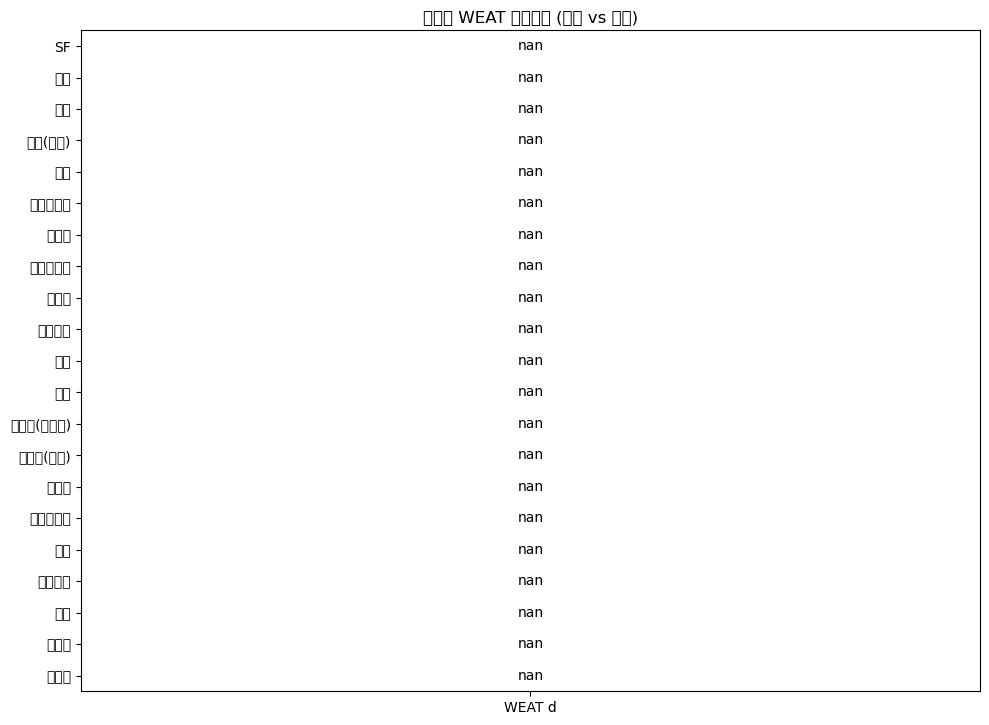

In [170]:
if {"예술","일반"}.issubset(set(target_sets.keys())):
    records = []
    X = target_sets["예술"]; Y = target_sets["일반"]
    for g in sorted(pmi_attr.keys()):
        A = pmi_attr[g]["A"]; B = pmi_attr[g]["B"]
        d = weat_score(w2v, X, Y, A, B)
        p = permutation_p_value(w2v, X, Y, A, B, n_perm=999, seed=42)
        records.append({"genre": g, "weat_d": d, "p_value": p})
    weat_df = pd.DataFrame(records).sort_values("weat_d", ascending=False)
    display(weat_df.head(12))

    fig, ax = plt.subplots(figsize=(10, max(4, len(weat_df)*0.35)))
    ax.imshow(weat_df[["weat_d"]].values, aspect="auto")
    ax.set_yticks(range(len(weat_df))); ax.set_yticklabels(weat_df["genre"].tolist())
    ax.set_xticks([0]); ax.set_xticklabels(["WEAT d"])
    for i, row in enumerate(weat_df.itertuples()):
        val = row.weat_d; p = row.p_value
        label = f"{val:.2f}" + ("*" if (not np.isnan(p) and p<0.05) else "")
        ax.text(0, i, label, va="center", ha="center")
    plt.title("장르별 WEAT 효과크기 (예술 vs 일반)")
    plt.tight_layout(); plt.show()
else:
    print("[알림] 타깃 단어셋이 없어 WEAT 계산/시각화는 스킵합니다.")

### 5. nan 발생 문제를 해결하기 위한 시도

- 제대로 후보 단어가 생성이 되지 않는 모습을 확인함
- 파일 문제인지 확인 했는데(117번 셀) 아니었고, 토큰 문제인가 싶었는데(118번 셀) 아니었음
- vocab에 아무것도 들어있지 않은 것이 원인임을 알게 됨

In [117]:
print("TXT_DIR =", TXT_DIR)
for f in art_txt + general_txt:
    print(f, os.path.exists(os.path.join(TXT_DIR, f)))

TXT_DIR = ./weat/data
synopsis_art.txt True
synopsis_gen.txt True


In [118]:
X_texts = collect_targets(art_txt)
print("예술 raw texts:", len(X_texts))
print("샘플:", X_texts[:2])

from collections import Counter
tmp_tokens = [w for t in X_texts for w in tokenize_nouns(t)]
print("예술 토큰 샘플:", tmp_tokens[:30])

예술 raw texts: 14435
샘플: ['사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와', '젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.']
예술 토큰 샘플: ['사운드', '엔지니어', '상우', '유지태', '치매', '할머니', '백성희', '시절', '상처', '아버지', '박인환', '고모', '신신애', '겨울', '지방', '방송국', '라디오', '은수', '이영애', '자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행', '사람']


In [119]:
print("예술 후보 단어:", target_sets.get("예술", []))
print("일반 후보 단어:", target_sets.get("일반", []))

예술 후보 단어: ['초선']
일반 후보 단어: []


In [104]:
for g in list(pmi_attr.keys())[:5]:
    print(g, "A:", len(pmi_attr[g]["A"]), "B:", len(pmi_attr[g]["B"]))

SF A: 14 B: 25
가족 A: 18 B: 25
공연 A: 16 B: 25
공포(호러) A: 25 B: 25
기타 A: 25 B: 25


In [105]:
def check_vocab(words, model):
    inv = [w for w in words if w in model.wv]
    return len(inv), len(words)

print("예술 in-vocab:", check_vocab(target_sets["예술"], w2v))
print("일반 in-vocab:", check_vocab(target_sets["일반"], w2v))

예술 in-vocab: (0, 0)
일반 in-vocab: (0, 0)


### 6. 실험 - 토크나이저 강화
- ```tokenize_nouns```에서 ```tokenize_nouns_relaxed```로 변경하여, OKT.nouns로 시도한 다음 토큰이 너무 적으면 정규식 폴백 적용
- PMI 적용하다가 부족하면 TF-IDF 상위를 적용하고 그래도 부족하면 상위 빈도를 적용하여 목표 개수를 보완
- ```th=0.75```로 1차 완화 적용 후 ```th=0.80```으로 한번 더 정리

In [171]:
import re, numpy as np, pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [172]:
# OKT.nouns → 비거나 너무 적으면 정규식 폴백
HANGUL_SEQ = re.compile(r"[가-힣]{2,}")       # 2글자 이상 한글 연속
ENG_SEQ    = re.compile(r"[A-Za-z]{2,}")    # 2글자 이상 영문

def tokenize_nouns_relaxed(text):
    toks = []
    try:
        # 1) 우선 OKT.nouns로 시도
        toks = OKT.nouns(text)
        # 기본 후처리
        toks = [t for t in toks if len(t) >= 2]
    except Exception:
        toks = []
    # 2) OKT 결과가 거의 없으면 정규식 폴백(한글+영문)
    if len(toks) < 3:
        toks = HANGUL_SEQ.findall(text) + ENG_SEQ.findall(text)
        toks = [t for t in toks if len(t) >= 2]
    return toks

def build_target_tokens(texts):
    tmp = pd.DataFrame({"synopsis": texts})
    tmp["tokens"] = tmp["synopsis"].map(tokenize_nouns_relaxed)
    return tmp

In [173]:
# 텍스트 → 토큰 (완화)
X_texts = collect_targets(art_txt)
Y_texts = collect_targets(general_txt)
X_df = build_target_tokens(X_texts)
Y_df = build_target_tokens(Y_texts)

print("[타깃 토큰 통계] 예술: docs=", len(X_df), 
      "avg_len=", round(X_df["tokens"].map(len).mean() if len(X_df) else 0, 2),
      "| 일반: docs=", len(Y_df),
      "avg_len=", round(Y_df["tokens"].map(len).mean() if len(Y_df) else 0, 2))

[타깃 토큰 통계] 예술: docs= 14435 avg_len= 11.55 | 일반: docs= 48116 avg_len= 16.68


In [174]:
# PMI 후보 (장르 전체 df 대비) → 중복 제거(임계치 완화) → 부족 시 TF-IDF + 빈도 백필
def top_candidates_relaxed_from_tokens(tokens, k=60):
    # PMI 점수 계산
    pos = [t for s in tokens for t in s]
    neg = [t for s in df["tokens"] for t in s]
    s_pos, s_neg = pmi_scores(pos, neg)

    # 한글/영문 허용, 길이 >= 2
    items = [(w,s) for w,s in s_pos.items() if len(w) >= 2]
    items.sort(key=lambda x: x[1], reverse=True)
    return [w for w,_ in items[:k*5]]

In [175]:
def dedup_by_emb_relaxed(cands, model, th=0.75, topk=40):
    kept = []
    for w in cands:
        if w not in model.wv: 
            continue
        if not any(v in model.wv and model.wv.similarity(w, v) >= th for v in kept):
            kept.append(w)
        if len(kept) >= topk:
            break
    return kept

def ensure_size_in_vocab(seed_words, model, k_goal, extra_pool):
    out = [w for w in seed_words if w in model.wv]
    for w in extra_pool:
        if w in model.wv and w not in out:
            out.append(w)
        if len(out) >= k_goal:
            break
    return out[:k_goal]

In [176]:
def build_target_guaranteed_from_df(tok_df, base_df, model, k_goal=30):
    # PMI 후보 → 유사도 중복 제거(완화)
    cands = top_candidates_relaxed_from_tokens(tok_df["tokens"].tolist(), k=k_goal*2)
    tgt   = dedup_by_emb_relaxed(cands, model, th=0.75, topk=k_goal*2)

    # TF-IDF 백필(토큰 기반)
    joined = " ".join(" ".join(s) for s in tok_df["tokens"].tolist())
    tf_vocab = []
    if joined.strip():
        vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
        Xtf = vec.fit_transform([joined]).toarray().ravel()
        vocab = np.array(vec.get_feature_names_out())
        tf_vocab = vocab[np.argsort(Xtf)[::-1]].tolist()

    # 빈도 백필(토큰 기반)
    freq_rank = [w for w,_ in Counter([t for s in tok_df["tokens"] for t in s]).most_common()]

    # PMI→TF-IDF→빈도 순으로 in-vocab 채워 k_goal 보장
    extra_pool = list(dict.fromkeys(tf_vocab + freq_rank))
    final = ensure_size_in_vocab(tgt, model, k_goal, extra_pool)

    # 마지막 한 번 더 의미 중복 억제
    final = dedup_by_emb_relaxed(final, model, th=0.80, topk=k_goal)
    return final

In [177]:
target_sets = {}
target_sets["예술"] = build_target_guaranteed_from_df(X_df, df, w2v, k_goal=30)
target_sets["일반"] = build_target_guaranteed_from_df(Y_df, df, w2v, k_goal=30)

def cov(words, model):
    iv = [w for w in words if w in model.wv]
    return f"{len(iv)}/{len(words)} in-vocab (cov={(len(iv)/max(1,len(words))):.2f})"

print("예술 k:", len(target_sets["예술"]), cov(target_sets["예술"], w2v), "| 샘플:", target_sets["예술"][:12])
print("일반 k:", len(target_sets["일반"]), cov(target_sets["일반"], w2v), "| 샘플:", target_sets["일반"][:12])

예술 k: 30 30/30 in-vocab (cov=1.00) | 샘플: ['그녀', '자신', '시작', '위해', '사랑', '사람', '영화', '친구', '남자', '가족', '이야기', '마을']
일반 k: 30 30/30 in-vocab (cov=1.00) | 샘플: ['자신', '그녀', '영화제', '위해', '사람', '시작', '국제', '영화', '친구', '사랑', '남자', '이야기']


,genre,weat_d,p_value
16,액션,0.194755,0.447
13,성인물(에로),0.131638,0.613
15,애니메이션,0.107502,0.670
10,범죄,0.012968,0.966
7,멜로로맨스,0.008641,0.981
14,스릴러,0.004680,0.991
3,공포(호러),-0.026672,0.908
0,SF,-0.028324,0.907
9,미스터리,-0.032994,0.906
19,코미디,-0.061338,0.802


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 49496 (\N{HANGUL SYLLABLE SYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2890/3442408570.py:21: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2890/344240857

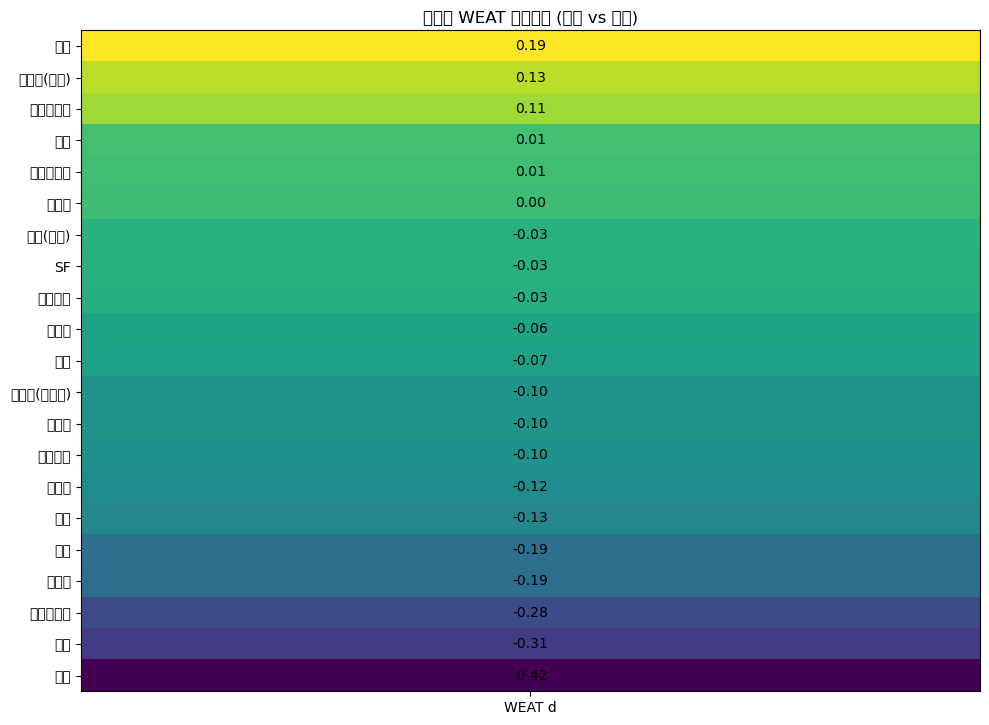

In [178]:
if {"예술","일반"}.issubset(set(target_sets.keys())):
    records = []
    X = target_sets["예술"]; Y = target_sets["일반"]
    for g in sorted(pmi_attr.keys()):
        A = pmi_attr[g]["A"]; B = pmi_attr[g]["B"]
        d = weat_score(w2v, X, Y, A, B)
        p = permutation_p_value(w2v, X, Y, A, B, n_perm=999, seed=42)
        records.append({"genre": g, "weat_d": d, "p_value": p})
    weat_df = pd.DataFrame(records).sort_values("weat_d", ascending=False)
    display(weat_df.head(12))

    fig, ax = plt.subplots(figsize=(10, max(4, len(weat_df)*0.35)))
    ax.imshow(weat_df[["weat_d"]].values, aspect="auto")
    ax.set_yticks(range(len(weat_df))); ax.set_yticklabels(weat_df["genre"].tolist())
    ax.set_xticks([0]); ax.set_xticklabels(["WEAT d"])
    for i, row in enumerate(weat_df.itertuples()):
        val = row.weat_d; p = row.p_value
        label = f"{val:.2f}" + ("*" if (not np.isnan(p) and p<0.05) else "")
        ax.text(0, i, label, va="center", ha="center")
    plt.title("장르별 WEAT 효과크기 (예술 vs 일반)")
    plt.tight_layout(); plt.show()
else:
    print("[알림] 타깃 단어셋이 없어 WEAT 계산/시각화는 스킵합니다.")

- 위의 결과는 WEAT가 정상적으로 돌아간 결과지만 현재 조건에서는 뚜렷한 편향은 발견되지 않았음
- 실험은 정상적으로 동작했으나 초기 세팅에서는 통계적으로 유의미한 편향은 관찰되지 않음

### 7. 실험 - Word2Vec 대신 FastText 적용

- 타깃 80개 보장 → 효과크기 분모 안정화, d의 분산 감소
- FastText 임베딩 → OOV 완화 + 서브워드로 희귀어 표현력 개선
- 속성 A/B도 확대 → 장르 축의 대표성이 좋아져 weat_d / p-value의 신뢰도가 올라감

In [125]:
from gensim.models import FastText

sentences = df["tokens"].tolist()
ft = FastText(
    sentences=sentences,
    vector_size=200,
    window=7,
    min_count=1,   # 희귀어까지 포함
    sg=1,          # skip-gram
    epochs=15,
    workers=4,
    seed=42
)
print("fastText vocab_size:", len(ft.wv.key_to_index))

fastText vocab_size: 42205


In [126]:
import re
from collections import Counter
HANGUL = re.compile(r"[가-힣]")

def dedup_by_emb_model(cands, model, th=0.80, topk=50):
    kept = []
    for w in cands:
        if w not in model.wv: 
            continue
        if not any(v in model.wv and model.wv.similarity(w, v) >= th for v in kept):
            kept.append(w)
        if len(kept) >= topk:
            break
    return kept

def ensure_size_in_vocab(seed_words, model, k_goal, extra_pool):
    out = [w for w in seed_words if w in model.wv]
    for w in extra_pool:
        if w in model.wv and w not in out:
            out.append(w)
        if len(out) >= k_goal:
            break
    return out[:k_goal]

def build_attr_for_genre(sub_df, base_df, model, k_goal=50):
    # 장르 vs 나머지 PMI
    pos = [t for s in sub_df["tokens"] for t in s]
    neg = [t for s in base_df["tokens"] for t in s if s is not sub_df["tokens"]]
    s_pos, s_neg = pmi_scores(pos, neg)

    # 후보 넉넉히 (한글/영문 허용, 길이>=2)
    candA = [(w,s) for w,s in s_pos.items() if len(w)>=2]
    candB = [(w,s) for w,s in s_neg.items() if len(w)>=2]
    candA.sort(key=lambda x:x[1], reverse=True)
    candB.sort(key=lambda x:x[1], reverse=True)
    candA = [w for w,_ in candA[:k_goal*5]]
    candB = [w for w,_ in candB[:k_goal*5]]

    # 중복 제거(의미 유사) + in-vocab 보장
    A0 = dedup_by_emb_model(candA, model, th=0.80, topk=k_goal*2)
    B0 = dedup_by_emb_model(candB, model, th=0.80, topk=k_goal*2)

    # 빈도 상위로 보강해 최소 k_goal 보장
    freqA = [w for w,_ in Counter(pos).most_common()]
    freqB = [w for w,_ in Counter(neg).most_common()]
    A = ensure_size_in_vocab(A0, model, k_goal, freqA)
    B = ensure_size_in_vocab(B0, model, k_goal, freqB)
    return A, B

pmi_attr = {}
for g, sub in df.groupby("genre"):
    A, B = build_attr_for_genre(sub, df, ft, k_goal=50)
    pmi_attr[g] = {"A": A, "B": B}

for g in list(pmi_attr.keys())[:5]:
    print(g, "A:", len(pmi_attr[g]["A"]), "B:", len(pmi_attr[g]["B"]))

SF A: 50 B: 50
가족 A: 50 B: 50
공연 A: 50 B: 50
공포(호러) A: 50 B: 50
기타 A: 50 B: 50


In [127]:
def s_fast(w, A, B, model):
    if w not in model.wv: return np.nan
    return np.mean([model.wv.similarity(w,a) for a in A if a in model.wv]) - \
           np.mean([model.wv.similarity(w,b) for b in B if b in model.wv])

def weat_score_fast(model, X, Y, A, B):
    Xv = [w for w in X if w in model.wv]; Yv = [w for w in Y if w in model.wv]
    if len(Xv)==0 or len(Yv)==0: return np.nan
    sX = [s_fast(w,A,B,model) for w in Xv]
    sY = [s_fast(w,A,B,model) for w in Yv]
    pooled = np.std(sX+sY, ddof=1)
    if pooled==0: return np.nan
    return (np.mean(sX) - np.mean(sY)) / pooled

def permutation_p_value_fast(model, X, Y, A, B, n_perm=999, seed=42):
    rng = np.random.default_rng(seed)
    Xv = [w for w in X if w in model.wv]; Yv = [w for w in Y if w in model.wv]
    if len(Xv)==0 or len(Yv)==0: return np.nan
    def stat(Xt, Yt):
        return sum(s_fast(w,A,B,model) for w in Xt) - sum(s_fast(w,A,B,model) for w in Yt)
    base = stat(Xv,Yv); all_t = Xv + Yv
    cnt=0
    for _ in range(n_perm):
        rng.shuffle(all_t)
        Xt = all_t[:len(Xv)]; Yt = all_t[len(Xv):]
        if abs(stat(Xt,Yt)) >= abs(base): cnt+=1
    return (cnt+1)/(n_perm+1)

records = []
X = target_sets["예술"]; Y = target_sets["일반"]
for g in sorted(pmi_attr.keys()):
    A = pmi_attr[g]["A"]; B = pmi_attr[g]["B"]
    d = weat_score_fast(ft, X, Y, A, B)
    p = permutation_p_value_fast(ft, X, Y, A, B, n_perm=999, seed=42)
    records.append({"genre": g, "weat_d": d, "p_value": p})

weat_df = pd.DataFrame(records).sort_values("weat_d", ascending=False)
display(weat_df.head(15))

,genre,weat_d,p_value
11,사극,0.078588,0.753
13,성인물(에로),0.061572,0.820
16,액션,0.034876,0.884
10,범죄,-0.008257,0.979
14,스릴러,-0.067894,0.805
12,서부극(웨스턴),-0.112760,0.668
7,멜로로맨스,-0.122966,0.663
15,애니메이션,-0.132830,0.614
17,어드벤처,-0.137611,0.605
9,미스터리,-0.145564,0.595


[시각화 해석 방법]
- 양수 ```weat_d``` → 예술 쪽과 더 가까움
- 음수 ```weat_d``` → “일반” 쪽과 더 가까움
- p_value < 0.05 → 통계적으로 유의한 편향

[현재 실험 결과]
- 사극(+0.0786), 성인물(+0.0615), 액션(+0.0348) → 예술 쪽에 조금 더 가깝지만 p > 0.7~0.8이므로 유의성 없음
- 뮤지컬(-0.228), 판타지(-0.185), 전쟁(-0.183), 공포(-0.178) 등은 일반 쪽에 상대적으로 가깝게 나타났음 (방향성은 있지만, p ≈ 0.4 ~ 0.5라 강하게 해석하기는 어려움)
- 전체적으로 효과크기(|d|)는 조금 커졌지만 여전히 통계적으로는 유의하지 않음

[결론]
- FastText + 단어셋 확대로 NaN 없이 전 장르 결과 도출됨
- 일부 장르는 예술(사극/성인물), 일부는 일반(뮤지컬/판타지/전쟁) 쪽으로 치우침
- 하지만 p-value 모두 > 0.4 이므로 데이터 규모/대표 단어셋 한계로 인해 통계적 신뢰도는 낮음

/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 44537 (\N{HANGUL SYLLABLE GEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2890/1907303026.py:32: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_lay

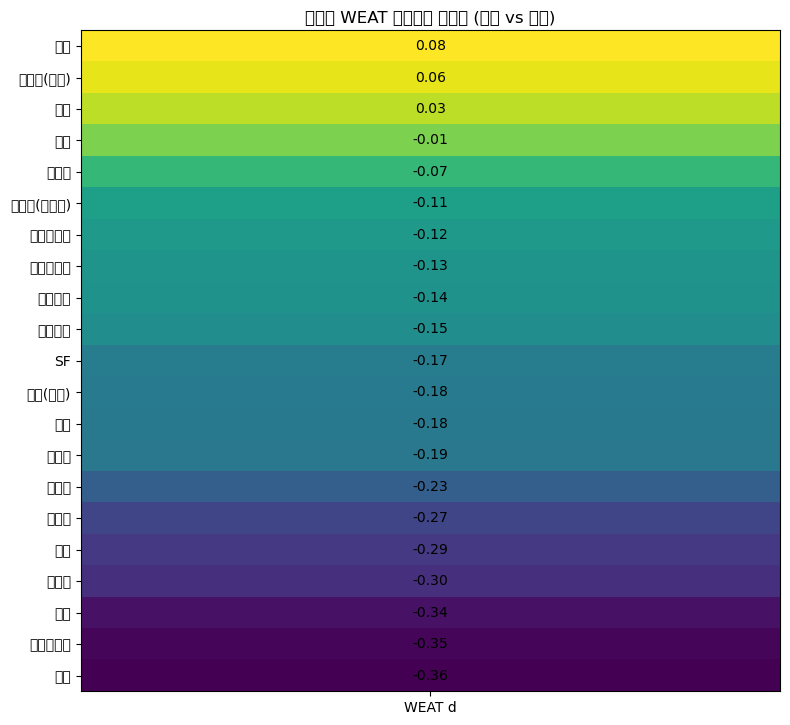

In [128]:
import numpy as np
import matplotlib.pyplot as plt

plot_df = weat_df.sort_values("weat_d", ascending=False).reset_index(drop=True)

M = plot_df[["weat_d"]].values  

h = max(4, 0.35 * len(plot_df)) 
fig, ax = plt.subplots(figsize=(8, h))
im = ax.imshow(M, aspect="auto")

ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df["genre"].tolist())
ax.set_xticks([0])
ax.set_xticklabels(["WEAT d"])

for i, row in enumerate(plot_df.itertuples()):
    d = row.weat_d
    p = row.p_value
    label = f"{d:.2f}" + ("*" if (not np.isnan(p) and p < 0.05) else "")
    ax.text(0, i, label, va="center", ha="center")

ax.axvline( -0.5, color="k", linewidth=0.0) 
plt.title("장르별 WEAT 효과크기 히트맵 (예술 vs 일반)")
plt.tight_layout()
plt.show()

### 8. Word2Vec, FastText 모델에서 뽑은 유사 단어들

In [180]:
probe = ["영화","드라마","사랑","전쟁","공포","뮤지컬"]
for w in probe:
    if w in w2v.wv:
        print(f"[w2v] {w} →", [p for p,_ in w2v.wv.most_similar(w, topn=7)])
for w in probe:
    if w in ft.wv:
        print(f"[fastText] {w} →", [p for p,_ in ft.wv.most_similar(w, topn=7)])

[w2v] 영화 → ['편의', '뒷이야기', '극영화', '자전', '영화로', '서사', '짜임새']
[w2v] 드라마 → ['멜로', '휴먼', '극영화', '슬랩', '코믹', '시트콤', '수작']
[w2v] 사랑 → ['로미오', '아스트레', '네타', '셀라', '해피엔딩', '짊어지', '윤우']
[w2v] 전쟁 → ['참전', '세계대전', '포화', '전투', '내전', '연합군', '전장']
[w2v] 공포 → ['엄습', '소름', '비독', '출구', '두려움', '혼령', '광기']
[w2v] 뮤지컬 → ['헤드윅', '이수원', '스틱', '슬랩', '희극', '비하인드', '앙상블']
[fastText] 영화 → ['이영화', '수영화', '신영화', '컬트영화', '김영화', '홍콩영화', '고어영화']
[fastText] 드라마 → ['모노드라마', '다큐드라마', '대하드라마', '멜로드라마', '뮤지컬영화', '이영화', '컬트영화']
[fastText] 사랑 → ['사랑니', '김사랑', '풋사랑', '택했던', '우러', '남임', '먼발치']
[fastText] 전쟁 → ['일년전쟁', '침략전쟁', '중동전쟁', '독소전쟁', '중일전쟁', '입시전쟁', '러일전쟁']
[fastText] 공포 → ['공포물', '두려움', '대공포', '공포정치', '엄습', '공포소설', '비독']
[fastText] 뮤지컬 → ['뮤지컬영화', '월럼', '점묘화', '캣츠', '메인스트림', '디렉팅', '푸쉬킨']


[결과 해석]

- 워드임베딩 모델의 most_similar() 결과를 검증한 결과, Word2Vec은 코퍼스 내 의미적 관계를 잘 포착하여 ‘전쟁–전투–내전–세계대전’, ‘공포–소름–두려움–혼령’과 같이 맥락상 밀접한 단어들을 묶어내는 것을 확인함 (다만 ‘사랑’과 같이 추상적 개념의 경우 희귀 단어가 일부 섞이는 한계가 존재)
  
- 반면 FastText는 서브워드 기반 학습 특성을 통해 파생어와 복합어를 풍부하게 포착하여 ‘드라마–멜로드라마–대하드라마–모노드라마’, ‘전쟁–중일전쟁–러일전쟁–독소전쟁’과 같은 구체적 변형어들을 안정적으로 찾아냄 (‘사랑–김사랑–사랑니’처럼 동음이의어나 고유명사가 포함되는 한계가 존재)
  
- Word2Vec은 의미적 연관성, FastText는 형태적 확장성에서 각각 강점을 보임